In [152]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io as io
import scipy.signal as sig
import math as math
import random 
from scipy import integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('seaborn-colorblind')
plt.rcParams['image.cmap'] = 'RdBu'

In [153]:
import matplotlib.pyplot as plt
import h5py

In [154]:
dfcrime = pd.read_csv('incidents_100k.csv')
dfcode = pd.read_csv('nbrhcodes.csv')
dfzip = pd.read_csv('area_zip_dict.csv')

In [155]:
#examine data
print(dfcrime.head(5))

   id        date  year  month   day  week  dow      time  hour  is_night  \
0 NaN  2008-09-19  2008      9  3184    37    5  13:00:00    13         0   
1 NaN  2008-07-20  2008      7  3123    28    0  22:00:00    22         1   
2 NaN  2009-05-25  2009      5  3432    21    1  00:30:00     0         1   
3 NaN  2011-04-22  2011      4  4129    16    5  19:10:00    19         0   
4 NaN  2012-05-12  2012      5  4515    19    6  21:40:00    21         1   

     ...     comm_pop council coun_pop  asr_zone lampdist        lat  \
0    ...        42779  San005   143957         1     3162  32.957337   
1    ...        15748  San003   147116         3     8000  32.758153   
2    ...        39849  San002   142456         6     2236  32.796761   
3    ...        45697  San003   147116         6     1414  32.757287   
4    ...        77873  San006   140738         1     6082  32.836098   

          lon                                    desc       gctype  gcquality  
0 -117.143777           

In [156]:
print(dfcode.head(5))

           type      city    code  scode                   name         lon  \
0  neighborhood  CaSanSAN  SanADM    103            Adams North -117.119183   
1  neighborhood  CaSanSAN  SanALL     51         Allied Gardens -117.081694   
2  neighborhood  CaSanSAN  SanALT    119             Alta Vista -117.065998   
3  neighborhood  CaSanSAN  SanAZL     12  Azalea/Hollywood Park -117.104734   
4  neighborhood  CaSanSAN  SanBAL     89            Balboa Park -117.145920   

         lat          area  
0  32.768792  2.115885e+07  
1  32.797943  6.459816e+07  
2  32.693359  7.690619e+06  
3  32.732939  9.612716e+06  
4  32.731088  5.686434e+07  


In [157]:
#grab necessary crime data
dfcrime = dfcrime[['year', 'type', 'nbrhood']]

In [158]:
#examine time range of crime records
#dfcrime['year'].value_counts()

In [159]:
#examine types of crime
#dfcrime['type'].value_counts()

In [160]:
#grab neighborhood codes
dfcode = dfcode[['code','name']]

In [161]:
# replace neighborhood codes with names in dfcrime
for i in range(len(dfcode)):
    name = dfcode['name'][i]
    key_code = dfcode['code'][i]
    
    dfcrime.replace(to_replace = key_code, value = name, inplace=True)

In [162]:
# replace spaces with '_' in neighborhood names
dfcrime['nbrhood'] = [str(x.replace(" ","_")) for x in dfcrime['nbrhood'][:]]

In [163]:
dfcrime.head(5)

,year,type,nbrhood
0,2008,WEAPONS,Rancho_Penasquitos
1,2008,FRAUD,Normal_Heights
2,2009,ASSAULT,Pacific_Beach
3,2011,DRUGS/ALCOHOL VIOLATIONS,North_Park
4,2012,ASSAULT,North_Clairemont


In [164]:
dfzip.head(5)

,Area,Zipcode
0,Jamul,91935
1,Wooded_Area,92106
2,Old_Town,92110
3,Spring_Valley,91977 91978
4,Pauma_Valley,92061


In [165]:
# remove neighborhoods in dfcrime for which we don't have the zipcode data for
area = dfzip['Area'].values
dfcrime = dfcrime[dfcrime['nbrhood'].isin(area)]
dfcrime

,year,type,nbrhood
0,2008,WEAPONS,Rancho_Penasquitos
1,2008,FRAUD,Normal_Heights
3,2011,DRUGS/ALCOHOL VIOLATIONS,North_Park
4,2012,ASSAULT,North_Clairemont
5,2010,ROBBERY,Clairemont_Mesa_East
7,2008,BURGLARY,North_Clairemont
8,2008,VEHICLE BREAK-IN/THEFT,Mission_Valley_East
10,2011,VEHICLE BREAK-IN/THEFT,Serra_Mesa
11,2011,ARSON,Hillcrest
12,2007,VEHICLE BREAK-IN/THEFT,Tierrasanta


In [166]:
# reset index of dfcrime
dfcrime = dfcrime.reset_index()
del dfcrime['index']

In [167]:
dfcrime

,year,type,nbrhood
0,2008,WEAPONS,Rancho_Penasquitos
1,2008,FRAUD,Normal_Heights
2,2011,DRUGS/ALCOHOL VIOLATIONS,North_Park
3,2012,ASSAULT,North_Clairemont
4,2010,ROBBERY,Clairemont_Mesa_East
5,2008,BURGLARY,North_Clairemont
6,2008,VEHICLE BREAK-IN/THEFT,Mission_Valley_East
7,2011,VEHICLE BREAK-IN/THEFT,Serra_Mesa
8,2011,ARSON,Hillcrest
9,2007,VEHICLE BREAK-IN/THEFT,Tierrasanta


In [168]:
# Sort values and group data by year and neighorhood to get total crimecount
dfcrime = dfcrime.sort_values(['year', 'nbrhood'], ascending=[True, True])
dfgroup = dfcrime.groupby(["year", "nbrhood"]).size()

# Take series and convert to dataframe. Reset index and rename columns
dfsort = dfgroup.to_frame()
dfsort = dfsort.reset_index()
dfsort.columns = ['year', 'nbrhood', 'crimecount']

In [169]:
zips = []
for i in range(len(dfsort['nbrhood'])):
    name = dfsort['nbrhood'][i]
    for j in range(len(dfzip['Zipcode'])):
        area = dfzip['Area'][j]
        zipcode = dfzip['Zipcode'][j]
        if name == area:
            zips.append(zipcode)


In [170]:
dfsort['zipcode'] = pd.Series(zips, index = dfsort.index)

In [171]:
del dfsort['nbrhood']

In [172]:
# sort by zipcode
dfsort = dfsort.sort_values(['zipcode', 'year'],ascending = [True, True])


In [173]:
dfsort = dfsort.reset_index()
del dfsort['index']

In [174]:
dfsort['zipcode'] = [int(x.replace(" ","")) for x in dfsort['zipcode'][:]]
dfsort

,year,crimecount,zipcode
0,2007,512,92037
1,2008,450,92037
2,2009,429,92037
3,2010,346,92037
4,2011,385,92037
5,2012,374,92037
6,2007,233,92101
7,2008,219,92101
8,2009,275,92101
9,2010,284,92101


In [175]:
#cv_count = dfsort[dfsort['zipcode'] == 92130] 
#lj_count = dfsort[dfsort['zipcode'] == 92037]
#barriologan_count = dfsort[dfsort['zipcode'] == 92113]
#northpark_count = dfsort[dfsort['zipcode'] == 92104]

#cv_crime = cv_count['crimecount']
#lj_crime = lj_count['crimecount']
#barriologan_crime = barriologan_count['crimecount']
#northpark_crime = northpark_count['crimecount']

#plt.plot(lj_count['year'], lj_count['crimecount'])

#avg_crime_cv = cv_crime.mean
#avg_crime_lj = lj_crime.mean
#avg_crime_bl = barriologan_crime.mean
#avg_crime_np = northpark_crime.mean



In [176]:
year_range = dfsort['year'].value_counts()
years = len(year_range)
year_list = list(year_range.keys())
year_list = sorted(year_list, key=int)   

zip_range = dfsort['zipcode'].value_counts()
zip_num = len(zip_range)
zip_list = list(zip_range.keys())
zip_list = sorted(zip_list, key = int)
zip_list

[92037,
 92101,
 92102,
 92103,
 92104,
 92105,
 92106,
 92107,
 92108,
 92109,
 92110,
 92111,
 92113,
 92114,
 92115,
 92116,
 92117,
 92119,
 92120,
 92121,
 92122,
 92123,
 92124,
 92126,
 92127,
 92128,
 92129,
 92130,
 92139,
 92154,
 92173]

In [177]:
crimebread = np.zeros((years,zip_num))
for i in range(years):
    for zips in zip_list:
        crimebread[i][:] = dfsort['crimecount'][dfsort['year'] == year_list[i]]

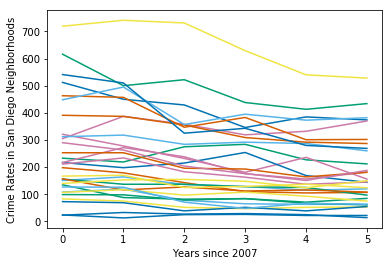

In [178]:
# graph crime rates throughout years 2007 - 2012 for all San Diego City Neighborhoods
plt.xlabel('Years since 2007')
plt.ylabel('Crime Rates in San Diego Neighborhoods')
_ = plt.plot(crimebread[:][:])

<Container object of 31 artists>

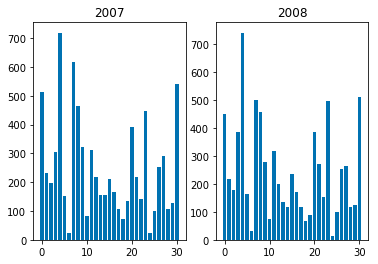

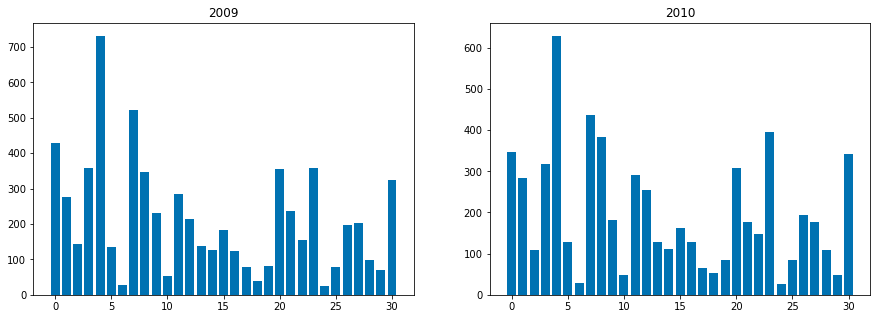

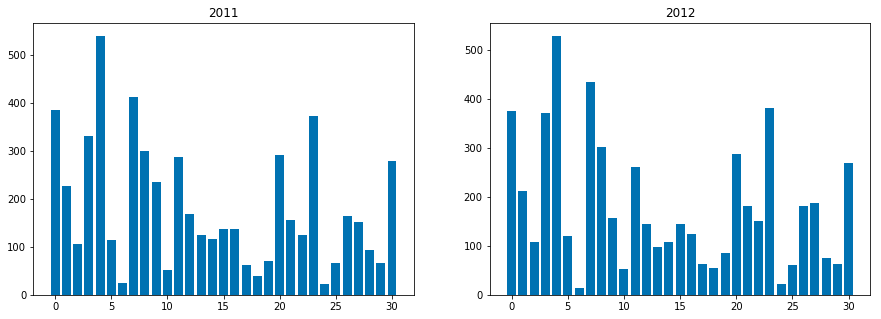

In [181]:
# prices across zipcodes color = each year
plt.xlabel('zipcodes')
plt.ylabel('crime rates in SD neighborhoods')
zipcrime_2007 = []
zipcrime_2008 = []
zipcrime_2009 = []
zipcrime_2010 = []
zipcrime_2011 = []
zipcrime_2012 = []

for j in range(len(crimebread)):
    for i in range(len(crimebread[j])):
        if j == 0:
            zipcrime_2007.append(crimebread[j][i])
        if j == 1:
            zipcrime_2008.append(crimebread[j][i])
        if j == 2:
            zipcrime_2009.append(crimebread[j][i])
        if j == 3:
            zipcrime_2010.append(crimebread[j][i])
        if j == 4:
            zipcrime_2011.append(crimebread[j][i])
        if j == 5:
            zipcrime_2012.append(crimebread[j][i])


plt.figure(1,figsize=(15,5))
plt.subplot(1,2,1)
plt.title(year_list[0])
plt.bar(list(range(31)), zipcrime_2007)
plt.subplot(1,2,2)
plt.title(year_list[1])
plt.bar(list(range(31)), zipcrime_2008)

plt.figure(2,figsize=(15,5))
plt.subplot(1,2,1)
plt.title(year_list[2])
plt.bar(list(range(31)), zipcrime_2009)
plt.subplot(1,2,2)
plt.title(year_list[3])
plt.bar(list(range(31)), zipcrime_2010)

plt.figure(3,figsize=(15,5))
plt.subplot(1,2,1)
plt.title(year_list[4])
plt.bar(list(range(31)), zipcrime_2011)
plt.subplot(1,2,2)
plt.title(year_list[5])
plt.bar(list(range(31)), zipcrime_2012)



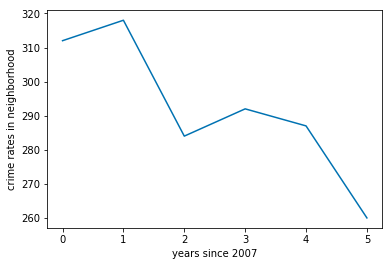

In [182]:
# accessing by each zipcode
plt.xlabel('years since 2007')
plt.ylabel('crime rates in neighborhood')
# color: each zipcode
_ = plt.plot(crimebread.T[:][11]) #La Jolla

In [27]:
import matplotlib.pyplot as plt
import h5py

#creating data
cogs108h5 = h5py.File('cogs108.h5', 'a')
cogs108h5.create_dataset('crime_rate', data = crimebread )
cogs108h5.close()


#load data from h5 
h5_file = '../cogs108_project/cogs108.h5'
#reading data
with h5py.File(h5_file, 'r') as h5:
    dset = h5['crime_rate']